# Calculate CESM Indeces

This file just calculates all the indeces for all months for all cesmFullForcingFiles.

Could be generalised if desired.

In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp

%run "utils/compound.ipynb"

In [2]:
import xarray
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

Data for climatology

In [ ]:
sstClimatDs=fh.loadModelData('CESM-LME', 'SST', '0850cntl.001')
pslClimatDs=fh.loadModelData('CESM-LME', 'PSL', '0850cntl.001')

sstClimat=sst.calculateClimatology(sstClimatDs, 850, 2005)
pslClimat=psl.calculateClimatology(pslClimatDs, 850, 2005)

#loading both those things
for keys in sstClimat:
    sstClimat[keys].load()
    
pslClimat.load()

In [ ]:
sstClimatDs.close()
pslClimatDs.close()

For each experiment in Full Forcings, calculate all the indeces

In [ ]:
timePIndeces=dict()

for experiment in _model.cesmAll:
    print(experiment)
    sstDs = fh.loadModelData('CESM-LME', 'SST', experiment)
    pslDs = fh.loadModelData('CESM-LME', 'PSL', experiment)
    pslIndex, junk = psl.calculateSamIndex(pslDs, pslClimat)
    sstIndex = sst.calculateIndex(sstDs, sstClimat) #(reducing the model set at this step could save time?)
    indeces = xarray.merge([pslIndex, sstIndex])
    indeces.assign_attrs(climatology='calculated based on 850-2005 climatology from the control run')
    indeces.to_netcdf('results/cesmMonthlyIndeces/' + experiment + '.nc')

    

# RCP8.5 extensions are a special case

    if experiment in ['002','003', '008', '009']:

        #pre2005Ds = xarray.load_dataset('results/cesmMonthlyIndeces/' + experiment + '.nc')

        print('LME.'+experiment)

        sstDs = fh.loadModelData('CESM-LME', 'SST', 'LME\.'+experiment)

        extensionSstIndex=sst.calculateIndex(sstDs, sstClimat)

        sstIndex = xarray.concat(
            [sstIndex,
             extensionSstIndex],
            'time'
        )


        pslDs = fh.loadModelData('CESM-LME', 'PSL', 'LME.'+experiment)

        extensionPslIndex, junk =psl.calculateSamIndex(pslDs, pslClimat)

        pslIndex=xarray.concat(
            [pslIndex,
             extensionPslIndex],
            'time'
        )

        indeces = xarray.merge([pslIndex, sstIndex])
        indeces.assign_attrs(climatology='calculated based on 850-1850 climatology')
        indeces.to_netcdf('results/cesmMonthlyIndeces/LME.' + experiment + '.nc')

    


In [ ]:
#loading both those things
for keys in sstClimat:
    sstClimat[keys].close()
    
pslClimat.close()

# Calculate CESM Indeces

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

In [4]:
#experimentSet = ['LME.002']
experimentSet = _model.cesmAll

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [5]:
timePIndeces=list()

for experiment in experimentSet:
    print(experiment)
    indecesDs = xarray.open_dataset('results/cesmMonthlyIndeces/' + experiment + '.nc')

    timePIndeces.append(tp.averageForTimePeriod(indecesDs))


results=xarray.concat(timePIndeces, 'experiment')


results['experiment']=experimentSet

results=results.assign_attrs({**indecesDs.attrs,**_index.monthsOfInterest})

LME.002
LME.003
LME.008
LME.009
0850cntl.001
001
002
003
004
005
006
007
008
009
010
011
012
013


Save the result for use later

In [6]:
results.to_netcdf('results/cesmTradIndeces.nc')

# Some sanity checks to see if it looks ok:


In [7]:
results

<xarray.Dataset>
Dimensions:          (experiment: 18, year: 1250)
Coordinates:
  * year             (year) int64 850 851 852 853 854 ... 2096 2097 2098 2099
  * experiment       (experiment) <U12 'LME.002' 'LME.003' ... '012' '013'
Data variables:
    dmi              (experiment, year) float64 0.9455 1.903 -0.352 ... nan nan
    eastIO           (experiment, year) float64 -0.4062 -1.1 0.428 ... nan nan
    nino34NoDetrend  (experiment, year) float64 0.5649 -0.5219 ... nan nan
    nino34           (experiment, year) float64 0.4477 -0.447 ... nan nan
    sam              (experiment, year) float64 -1.059 0.2726 0.2454 ... nan nan
    nino4NoDetrend   (experiment, year) float64 0.6418 -0.3102 ... nan nan
    nino4            (experiment, year) float64 0.5246 -0.2353 ... nan nan
    eastIONoDetrend  (experiment, year) float64 -0.3048 -1.163 ... nan nan
Attributes:
    nino34NoDetrend:  [7, 15]
    nino4NoDetrend:   [7, 15]
    eastIONoDetrend:  [7, 12]
    dmi:              [7, 12]
    nino34:           [7, 15]
    nino4:            [7, 15]
    eastIO:           [7, 12]
    sam:              [10, 15]
    lat1:             [10, 15]
    lat2:             [10, 15]
    precAnom:         [9, 15]
    tsAnom:           [9, 15]

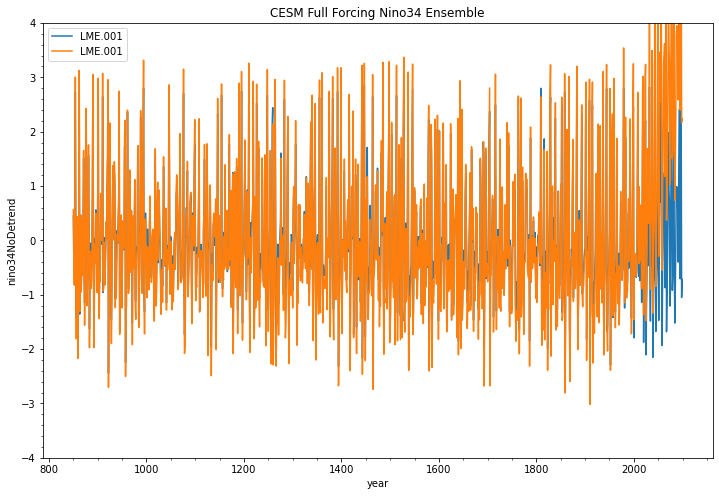

In [8]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

#results.sel(experiment='001', index='nino34').plot(label='001')
results.nino34.sel(experiment='LME.002').plot(label='LME.001')
results.nino34NoDetrend.sel(experiment='LME.002').plot(label='LME.001')

#Tidy up a bit
plt.title("CESM Full Forcing Nino34 Ensemble")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [9]:
# A multi-experiment mean?

mean = results.sam.mean(dim='experiment')
std = results.sam.std(dim='experiment')

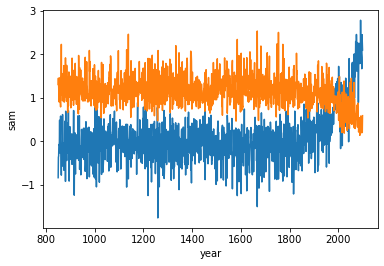

In [10]:
plt.figure()
mean.plot()
std.plot()

In [11]:
# why limit yourself to one index?

mean = results.mean(dim='experiment')
std = results.std(dim='experiment')

In [12]:
std

<xarray.Dataset>
Dimensions:          (year: 1250)
Coordinates:
  * year             (year) int64 850 851 852 853 854 ... 2096 2097 2098 2099
Data variables:
    dmi              (year) float64 0.9818 1.109 1.06 ... 1.434 0.9272 1.895
    eastIO           (year) float64 0.7665 0.8233 0.853 ... 1.408 0.724 1.552
    nino34NoDetrend  (year) float64 0.7724 1.354 1.196 ... 1.902 1.098 1.768
    nino34           (year) float64 0.6606 1.123 1.049 ... 1.604 0.9819 1.434
    sam              (year) float64 1.3 1.446 1.271 ... 0.3166 0.2177 0.5836
    nino4NoDetrend   (year) float64 0.542 0.8852 0.9618 ... 1.081 1.115 1.089
    nino4            (year) float64 0.432 0.7168 0.8207 ... 0.7913 1.01 0.8264
    eastIONoDetrend  (year) float64 0.7231 0.7881 0.763 ... 1.13 0.5849 1.229

# Calculate Compound Years for CESM

In [13]:
# Here is the data
indecesDs = xarray.open_dataset('results/cesmTradIndeces.nc')

indecesDs.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '0850cntl.001', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

In [14]:
indecesDs

<xarray.Dataset>
Dimensions:          (experiment: 18, year: 1250)
Coordinates:
  * year             (year) int64 850 851 852 853 854 ... 2096 2097 2098 2099
  * experiment       (experiment) object 'LME.002' 'LME.003' ... '012' '013'
Data variables:
    dmi              (experiment, year) float64 ...
    eastIO           (experiment, year) float64 ...
    nino34NoDetrend  (experiment, year) float64 ...
    nino34           (experiment, year) float64 ...
    sam              (experiment, year) float64 ...
    nino4NoDetrend   (experiment, year) float64 ...
    nino4            (experiment, year) float64 ...
    eastIONoDetrend  (experiment, year) float64 ...
Attributes:
    nino34NoDetrend:  [ 7 15]
    nino4NoDetrend:   [ 7 15]
    eastIONoDetrend:  [ 7 12]
    dmi:              [ 7 12]
    nino34:           [ 7 15]
    nino4:            [ 7 15]
    eastIO:           [ 7 12]
    sam:              [10 15]
    lat1:             [10 15]
    lat2:             [10 15]
    precAnom:         [ 9 15]
    tsAnom:           [ 9 15]

# Define a criteria to determine events

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [76]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDs.sel(experiment=_model.cesmCntl).std(dim='year')

In [77]:
# define some criteria that we want to use to identifiy it thats an event. Its the same for evey experiment this time
criteriaDa= xarray.merge(
    (stdDa[['nino34','dmi']], stdDa['sam']/2)
)

criteriaDa = xarray.concat([
    criteriaDa for i in range(0,len(_model.cesmAll))
], 'experiment')
criteriaDa['experiment'] = _model.cesmAll

criteriaDa

<xarray.Dataset>
Dimensions:     (experiment: 18)
Coordinates:
  * experiment  (experiment) <U12 'LME.002' 'LME.003' 'LME.008' ... '012' '013'
Data variables:
    nino34      (experiment) float64 1.05 1.05 1.05 1.05 ... 1.05 1.05 1.05 1.05
    dmi         (experiment) float64 1.309 1.309 1.309 ... 1.309 1.309 1.309
    sam         (experiment) float64 0.6559 0.6559 0.6559 ... 0.6559 0.6559

# Calculate the compounding years and plot an example

In [78]:
%run utils/compound.ipynb



firePos, fireNeg = applyCriteria(indecesDs, criteriaDa)

firePos=compound(firePos)

fireNeg=compound(fireNeg)

firePos.to_netcdf('results/cesmFirePos.nc')

fireNeg.to_netcdf('results/cesmFireNeg.nc')

In [79]:
firePos

<xarray.Dataset>
Dimensions:     (experiment: 18, year: 1250)
Coordinates:
  * year        (year) int64 850 851 852 853 854 ... 2095 2096 2097 2098 2099
  * experiment  (experiment) object 'LME.002' 'LME.003' ... '012' '013'
Data variables:
    nino34      (experiment, year) bool False False False ... False False False
    dmi         (experiment, year) bool False True False ... False False False
    sam         (experiment, year) bool True False False ... False False False
    nEvents     (experiment, year) int32 1 1 0 1 2 1 0 1 0 ... 0 0 0 0 0 0 0 0 0
    all3        (experiment, year) bool False False False ... False False False
    nino34+dmi  (experiment, year) bool False False False ... False False False
    nino34+sam  (experiment, year) bool False False False ... False False False
    dmi+sam     (experiment, year) bool False False False ... False False False
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']

Text(0.5, 1.0, 'LME.002: Pairs and all-three compounds for individal years')

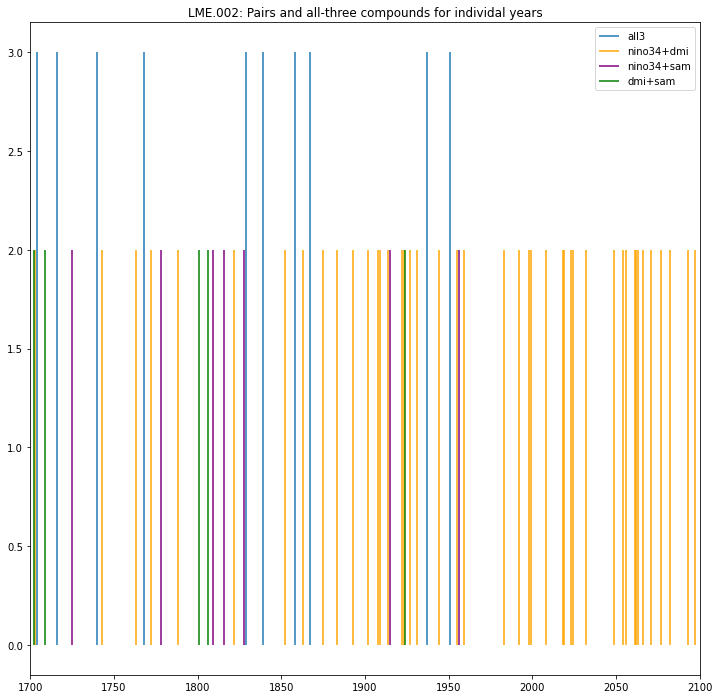

In [80]:
expToPlot = 'LME.002'

toPlot=3*firePos.all3.sel(experiment=expToPlot)

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos[iPair].sel(experiment=expToPlot),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1700,2100)
plt.title(expToPlot+': Pairs and all-three compounds for individal years')